In [577]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

# 1. Rotação

In [679]:
def rotate(img, ang):
    
    ang = ang*(np.pi/180) #converte de graus para radiano
    r, c = img.shape[0:2] #r = n linhas, c = n colunas
    
    #coordenadas do centro da imagem, para rotacionar em volta dele
    ic = r/2 - 1
    jc = c/2 - 1
    
    #imagem rotacionada iniciada com zeros. Dimensoes são tais para poder abrigar o maior
    #retangulo rotacionado possível (ang = 45)
    r_rot = int(round(r*np.sqrt(2)))
    c_rot = int(round(c*np.sqrt(2)))
    M_rot = np.zeros((r_rot, c_rot, 3),dtype='uint8')
    
    #usados para centralizar a imagem rotacionada na imagem de destino, para evitar que 
    #alguns pixels fiquem com indice negativo
    icc = int(round((r_rot-r)/2))
    jcc = int(round((c_rot-c)/2))
    
    #mapeamento reverso
    M = np.zeros((r+1,c+1,3),dtype='uint8')
    
    #para cada ponto na imagem, realiza a rotacao
    for i in range(r):
        for j in range(c):
            il = int(round((i-ic)*np.cos(ang) - (j-jc)*np.sin(ang) + ic))
            jl = int(round((i-ic)*np.sin(ang) + (j-jc)*np.cos(ang) + jc))
            #tons de cinza
            M_rot[il+icc, jl+jcc,0] = img[i,j,0]
            M_rot[il+icc, jl+jcc,1] = M_rot[il+icc, jl+jcc,0]
            M_rot[il+icc, jl+jcc,2] = M_rot[il+icc, jl+jcc,0]
            #mapeamento reverso
            ii = int(round((il-ic)*np.cos(ang) + (jl-jc)*np.sin(ang) + ic))
            jj = int(round((-1*(il-ic))*np.sin(ang) + (jl-jc)*np.cos(ang) + jc))
            #tons de cinza
            M[ii,jj,0] = M_rot[il+icc,jl+jcc,0]
            M[ii,jj,1] = M[ii,jj,0]
            M[ii,jj,2] = M[ii,jj,0]
            
    return M_rot, M

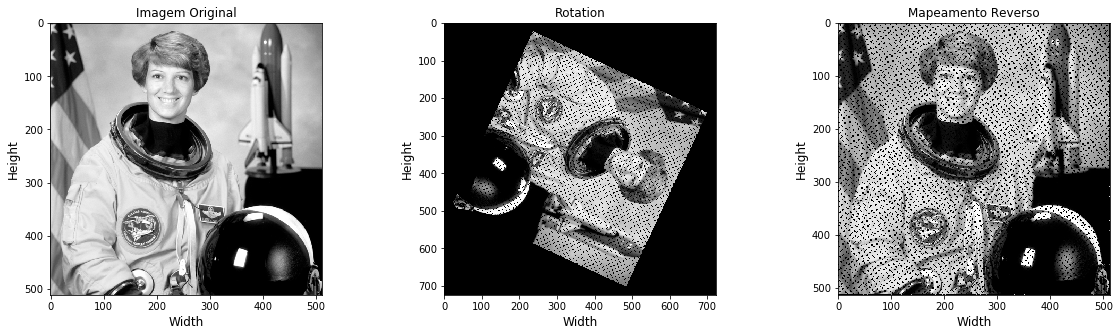

In [686]:
img = io.imread("imageio:astronaut.png")
#tons de cinza
img[:,:,1] = img[:,:,0]
img[:,:,2] = img[:,:,0]

r, c = img.shape[0:2]
Mdes, M = rotate(img, 245)

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].set_title('Imagem Original', fontsize=12)
ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_xlabel('Width', fontsize=12)
ax[0].imshow(img)

ax[1].set_title('Rotation', fontsize=12)
ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_xlabel('Width', fontsize=12)
ax[1].imshow(Mdes)

ax[2].set_title('Mapeamento Reverso', fontsize=12)
ax[2].set_ylabel('Height', fontsize=12)
ax[2].set_xlabel('Width', fontsize=12)
ax[2].imshow(M)